In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from mc_agent import MLWrapper, CostSurface, MCAgent # custom ML classes
from mc_agent import normalize

## Loadings and Processing Rasters
- The `CostSurface` class can be used to load already processed cost and no-go arrays or process them on the fly.
- Below are examples to load pre-processed rasters and process a raw raster

In [2]:
# Load the pre-processed cost surfaces
cost_surface = CostSurface()
cost_surface.load_rasters('./cost_surfaces/raw_cost_10km_aea')

### Linear vs Exponential Normalization
- Using an exponential weighting of the cost surface allows the high cost areas to be penalized more than they normally would be with a liner weighting
- Let $c$ be the cost of a pixel and $d$ be the degree then:

Linear:
$$
c = c
$$

Exponential:
$$
c = c^{d}
$$



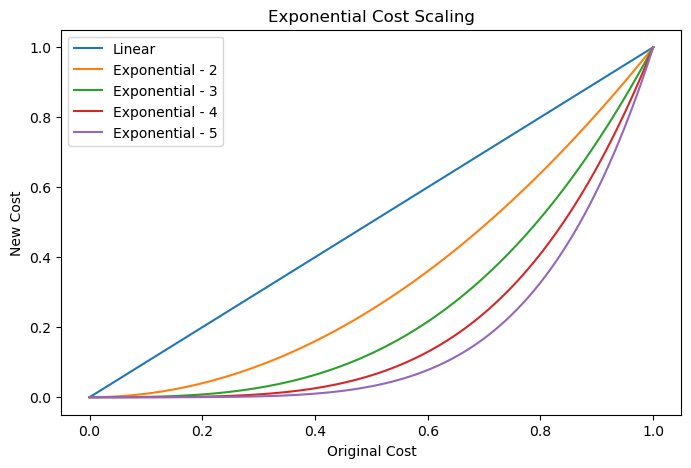

In [3]:
def linear(x):
    return x

def exponential(x, degree):
    return x**degree

x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_ylabel('New Cost')
ax.set_xlabel('Original Cost')
ax.set_title('Exponential Cost Scaling')

y = normalize(linear(x))
ax.plot(x, y)
labels = ['Linear']
for d in range(2,6):
    y = normalize(exponential(x, d))
    ax.plot(x,y)
    labels.append('Exponential - {}'.format(d))

ax.legend(labels)
plt.show()


### Preprocessed Raster

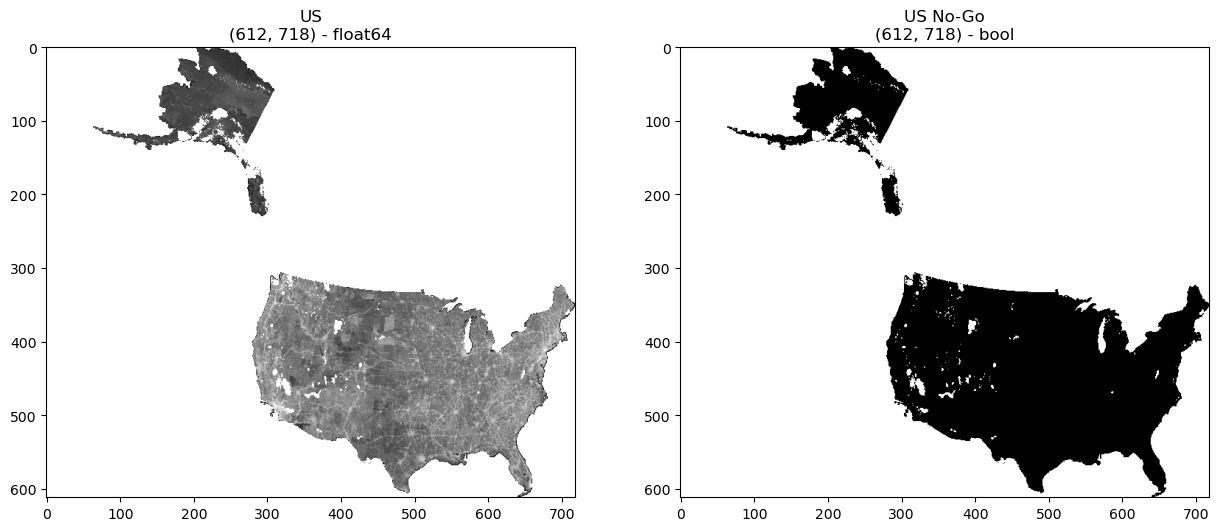

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

ax[0].set_title('US\n{} - {}'.format(cost_surface.cost.shape, cost_surface.cost.dtype))
ax[0].imshow(cost_surface.cost, cmap='gray')

ax[1].imshow(cost_surface.no_go, cmap='gray')
ax[1].set_title('US No-Go\n{} - {}'.format(cost_surface.no_go.shape, cost_surface.no_go.dtype))

plt.show()

### Process with `CostSurface`

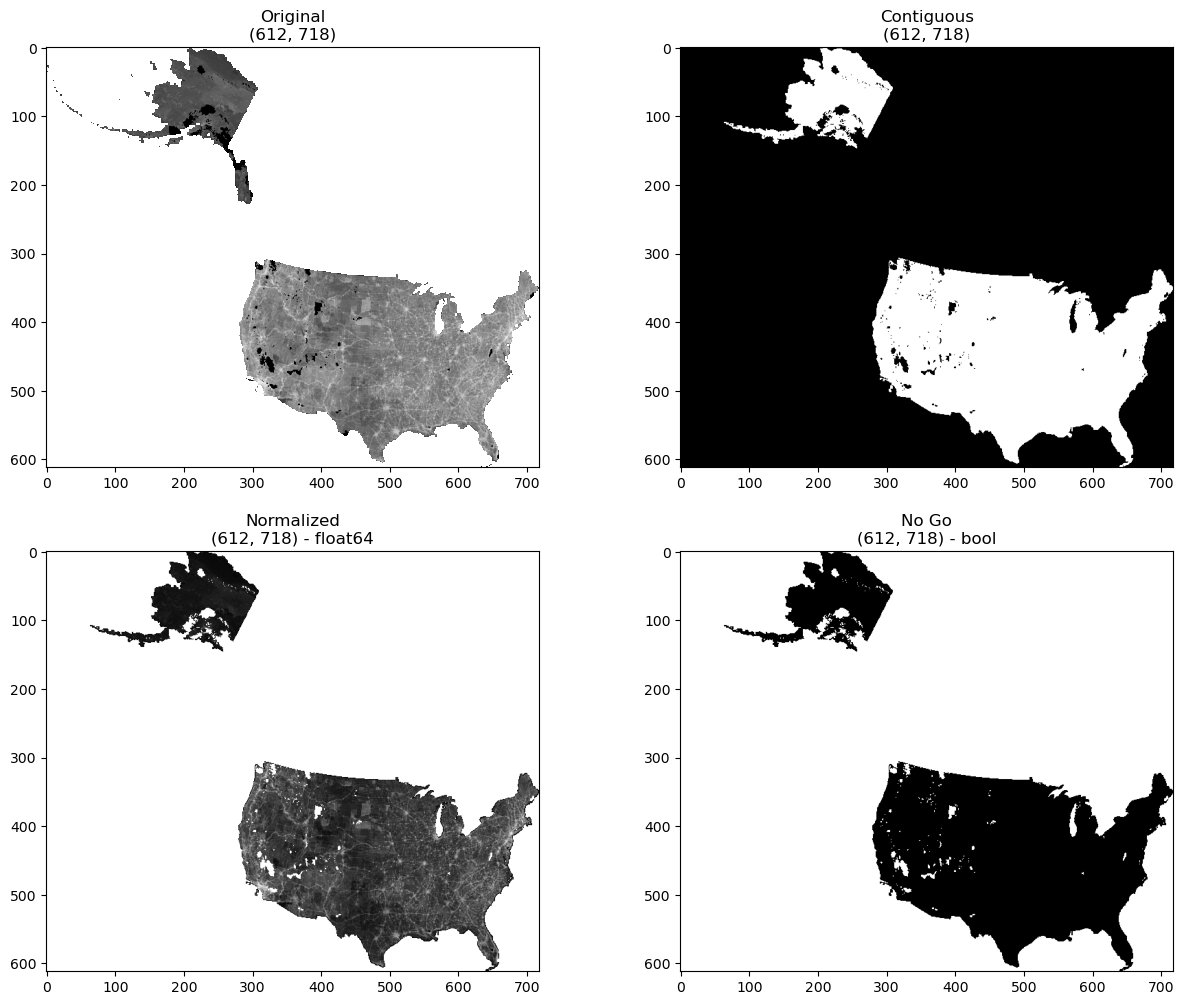

In [5]:
cost_surface = CostSurface()
raw_raster_path = './cost_surfaces/raw_cost_10km_aea/cost_10km_aea.tif'
# Setting no-go cost to out of bounds cost will prevent the agent from making
# any moves through the high cost "no-go" areas
cost_surface.process_raster(raw_raster_path, visualize=True)

In [6]:
def normalize(arr, high=1, low=0):
    norm = (high-low)*(arr - arr.min())/(arr.max() - arr.min()) + low
    return norm

### Load Original
- Below the original raster file is loaded for comparison and visualizations

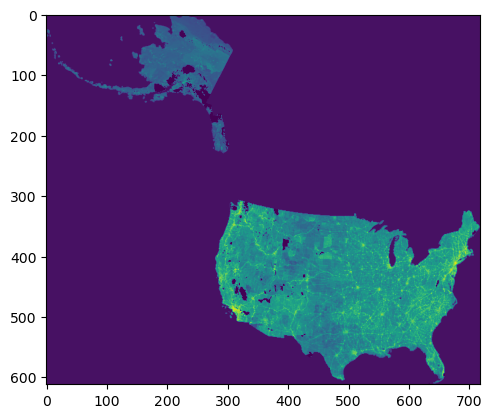

In [7]:
# For comparison take a look at the original raster
path = './cost_surfaces/raw_cost_10km_aea/cost_10km_aea.tif'
ds = rasterio.open(path)
original = ds.read(1)
image = original.copy()
# original = np.array(img)
# clip = original[:400,:750]
# clip[clip==np.inf] = 0
# clip[clip==-1] = 0
# norm = normalize (clip)
# print(norm.shape)
# print(norm.max())
# print(norm.min())
image[image<-1]=0
plt.imshow(image)
plt.show()

## Supporting Functions
- Below are supporting functions for this demo
- They are not required for the MC agent to function
- These functions are included here to confirm proper coordinate conversions and visualizations

In [8]:
def generate_locations(no_go, start, target, rng, max_distance=50):
    """
    Can be used to generate valid start and target locations
    """

    while start is None:
        shape = no_go.shape
        y = rng.integers(0, shape[0], 1)[0]
        x = rng.integers(0, shape[1], 1)[0]
        if not no_go[y, x]:
            start = (y, x)
    
    while target is None:
        shape = no_go.shape
        y = rng.integers(
            max(0, start[0]-max_distance), 
            min(shape[0], start[0] + max_distance),
            1
        )
        y = y[0]

        x = rng.integers(
            max(0, start[1]-max_distance), 
            min(shape[1], start[1] + max_distance),
            1
        )
        x = x[0]

        if not no_go[y, x]:
            target = (y, x)

    return start, target

In [9]:
def draw_circle(img, start, target, radius):
    """
    Creates a three channel colored image with start and target locations.
    """
    r = img.copy()
    g = np.zeros(img.shape)
    b = np.zeros(img.shape)

    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    
    circle = (y-start[0])**2 + (x-start[1])**2
    b[circle < radius**2] = 1

    circle = (y-target[0])**2 + (x-target[1])**2
    g[circle < radius**2] = 1

    r = np.expand_dims(r, axis=2)
    g = np.expand_dims(g, axis=2)
    b = np.expand_dims(b, axis=2)

    new_img = np.concatenate((r,g,b), axis=2)

    return new_img

def draw_circle(img, center, radius):
    """
    Modifies the specified img in place by drawing a circle on it.
    """
    img = img.copy()
    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    circle = (y-center[0])**2 + (x-center[1])**2
    img[circle < radius**2] = 1

    return img

def visualize(cost_surface, agent, target, locations=[], path=[], radius=5):
    
    # Build observation
    shape = (3, *cost_surface.shape)
    obs = np.zeros(shape, dtype=np.float32)

    # Set red channel equal to the given cost surface
    obs[0,:,:] = cost_surface.copy()

    # Set green channel to target location
    obs[1,:,:] = draw_circle(
        np.zeros((cost_surface.shape), dtype=np.float32), 
        center=target,
        radius=radius
        )
    
    # Set blue channel to agent location
    obs[2,:,:] = draw_circle(
        np.zeros((cost_surface.shape), dtype=np.float32), 
        center=agent,
        radius=radius
        )
    
    # Record path through the surface
    if path:
        all_y, all_x = zip(*path)
        obs[:, all_y, all_x] = 1

    elif locations:
        all_y, all_x = zip(*locations)
        obs[:, all_y, all_x] = 1
        
    return obs

## Visualize Start & End Locations
- The next session shows several starting and ending locations
- The visualizations plot these locations for the original and processed raster

(400, 315)
(386, 386)


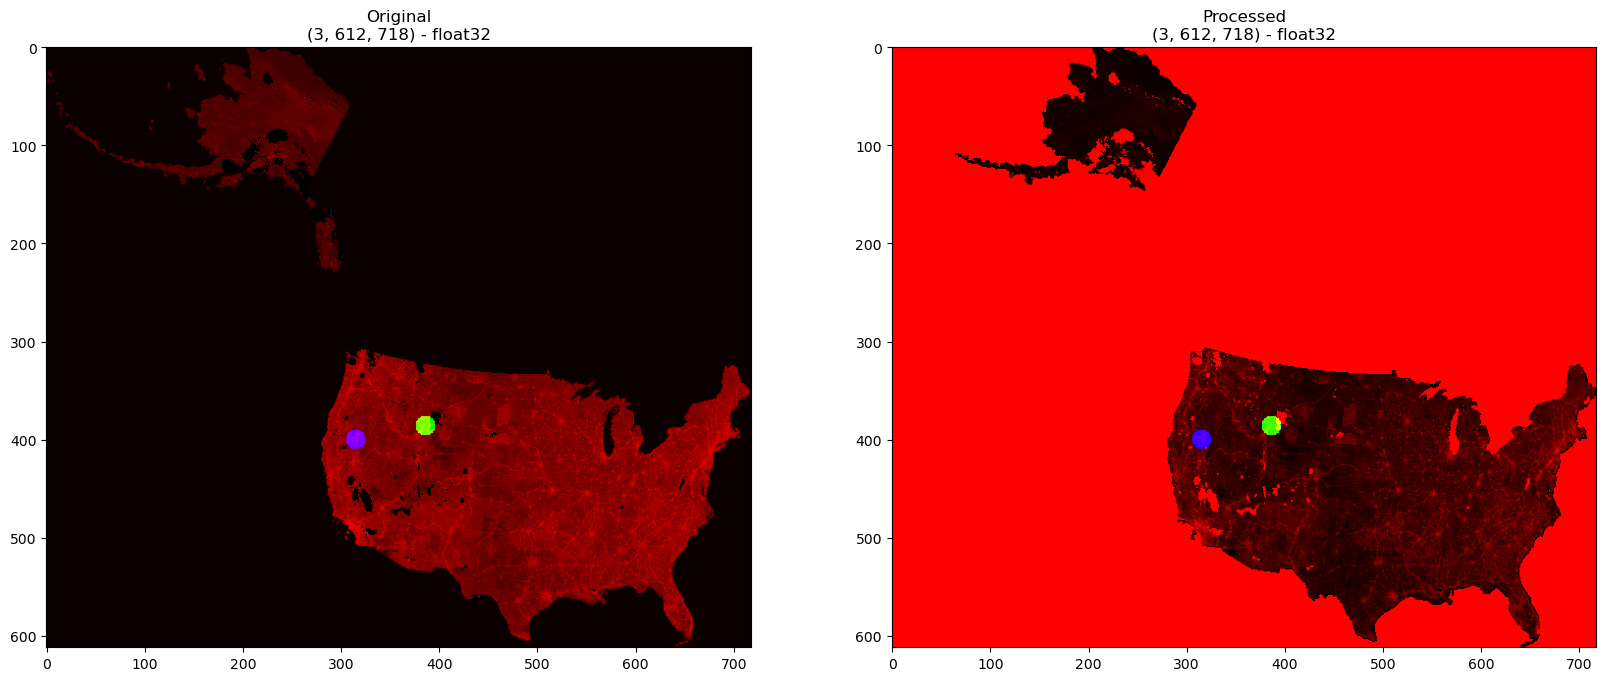

In [10]:
rng = np.random.default_rng(seed=42)
start, target = generate_locations(cost_surface.no_go, start=None, target=None, rng=rng, max_distance=100)

print(start)
print(target)

org_raster = visualize(normalize(image.copy()), start, target, radius=10)
processed_raster = visualize(cost_surface.cost.copy(), start, target, radius=10)

fig, ax = plt.subplots(ncols=2, figsize=(20, 12))
ax[0].imshow(np.moveaxis(org_raster, 0, -1))
ax[0].set_title('Original\n{} - {}'.format(org_raster.shape, org_raster.dtype))
ax[1].imshow(np.moveaxis(processed_raster, 0, -1))
ax[1].set_title('Processed\n{} - {}'.format(processed_raster.shape, processed_raster.dtype))
plt.show()

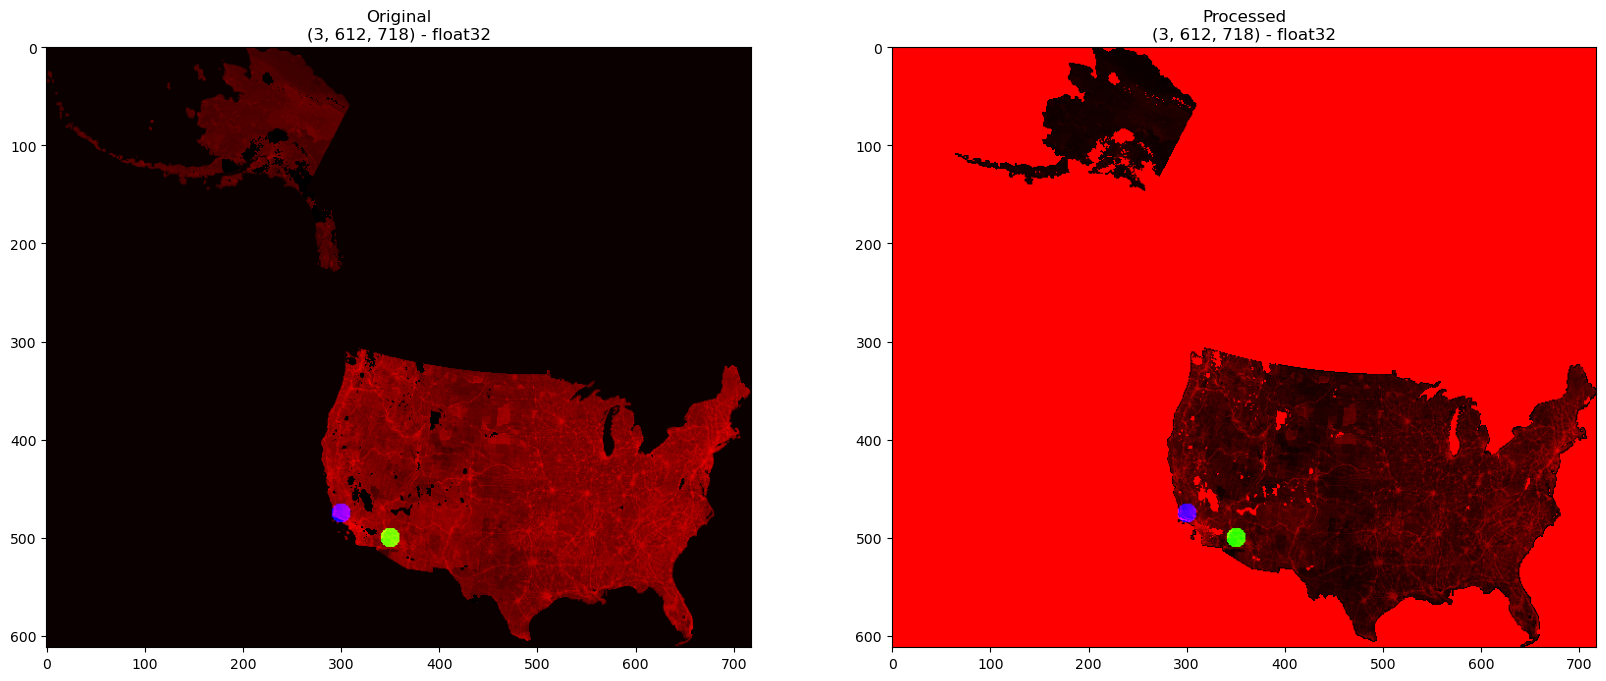

In [11]:
start, target = (475, 300), (500, 350)

org_raster = visualize(normalize(image.copy()), start, target, radius=10)
processed_raster = visualize(cost_surface.cost.copy(), start, target, radius=10)

fig, ax = plt.subplots(ncols=2, figsize=(20, 12))
ax[0].imshow(np.moveaxis(org_raster, 0, -1))
ax[0].set_title('Original\n{} - {}'.format(org_raster.shape, org_raster.dtype))
ax[1].imshow(np.moveaxis(processed_raster, 0, -1))
ax[1].set_title('Processed\n{} - {}'.format(processed_raster.shape, processed_raster.dtype))
plt.show()

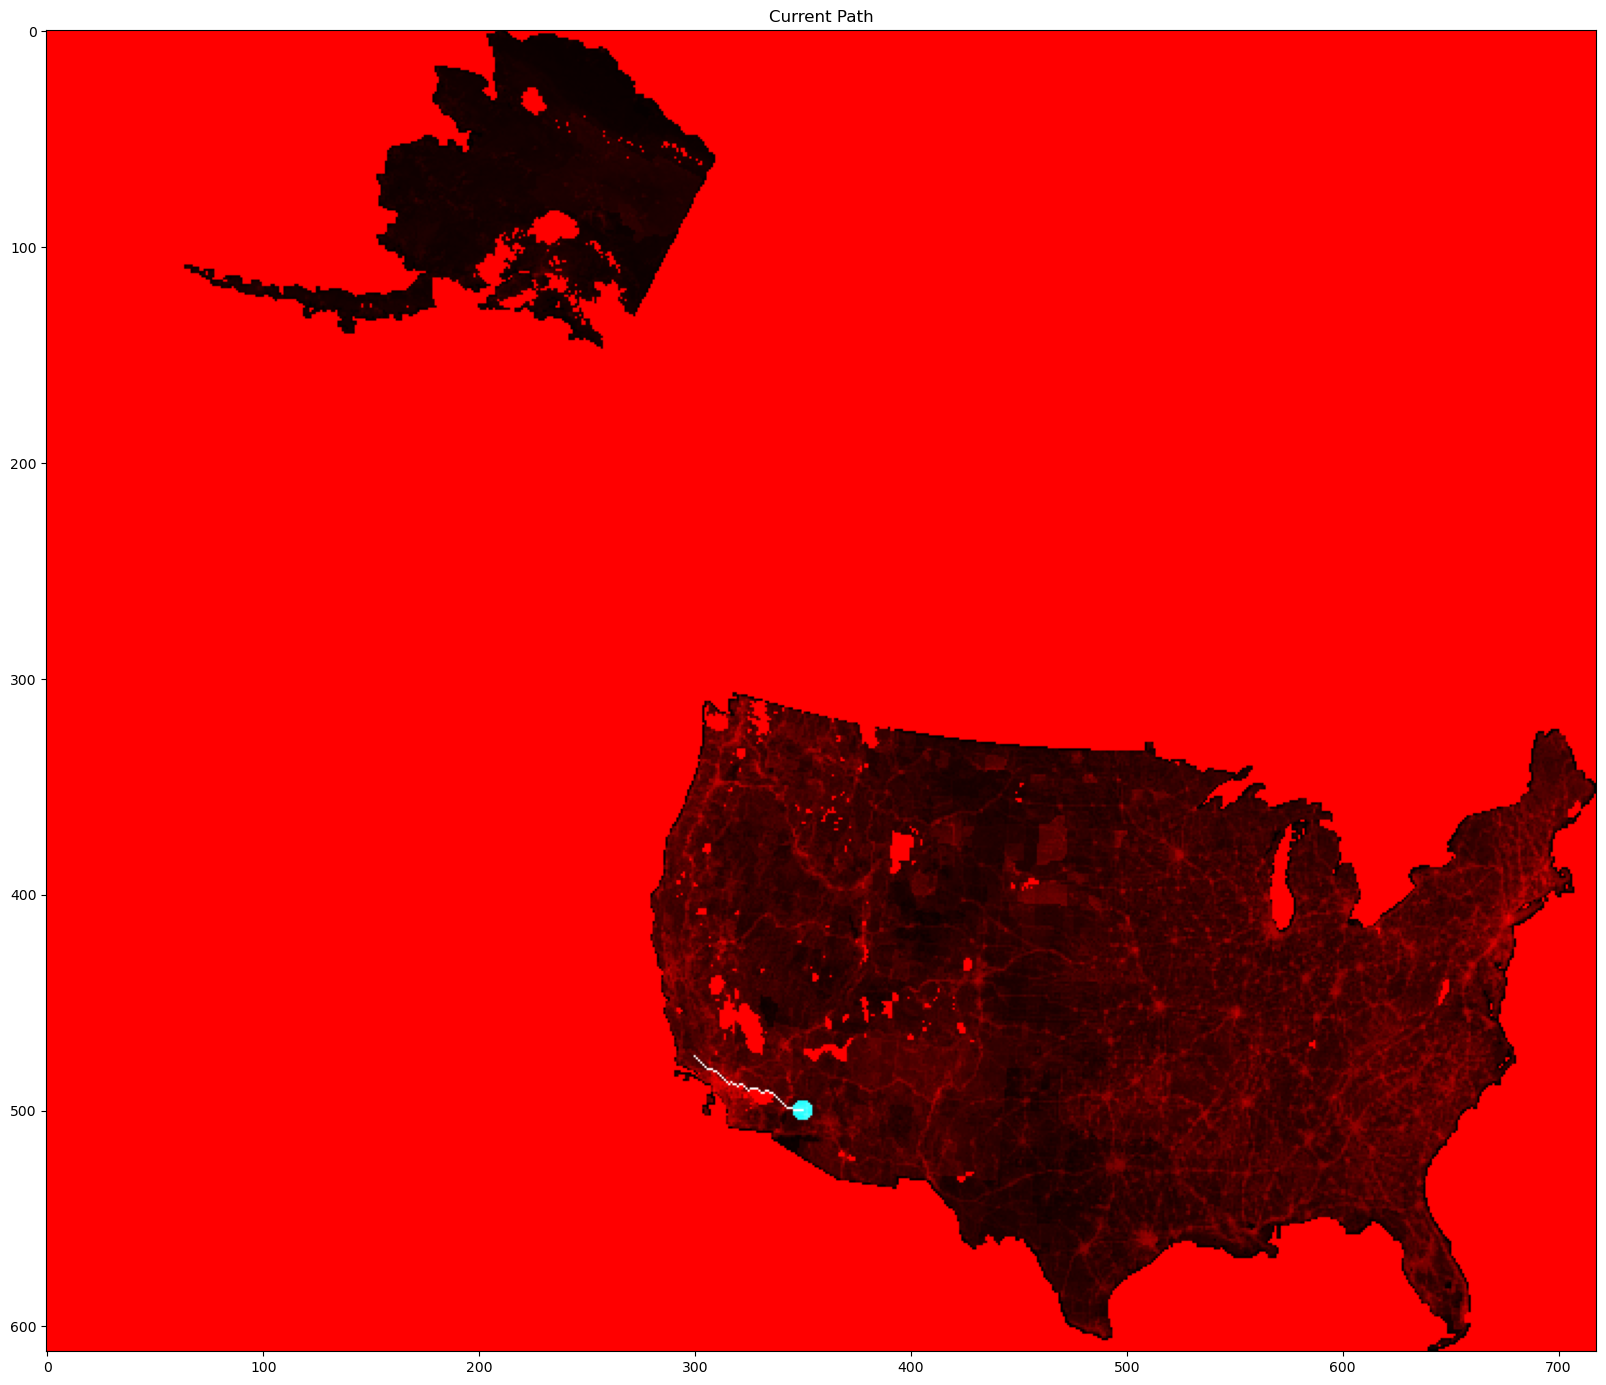

In [12]:
# Define agent which makes routing choices
agent = MCAgent(100, 1)
path = agent.route(
    cost_surface=cost_surface.cost,
    start=list(start),
    target=list(target),
    show_viz=True
    )

Path generated


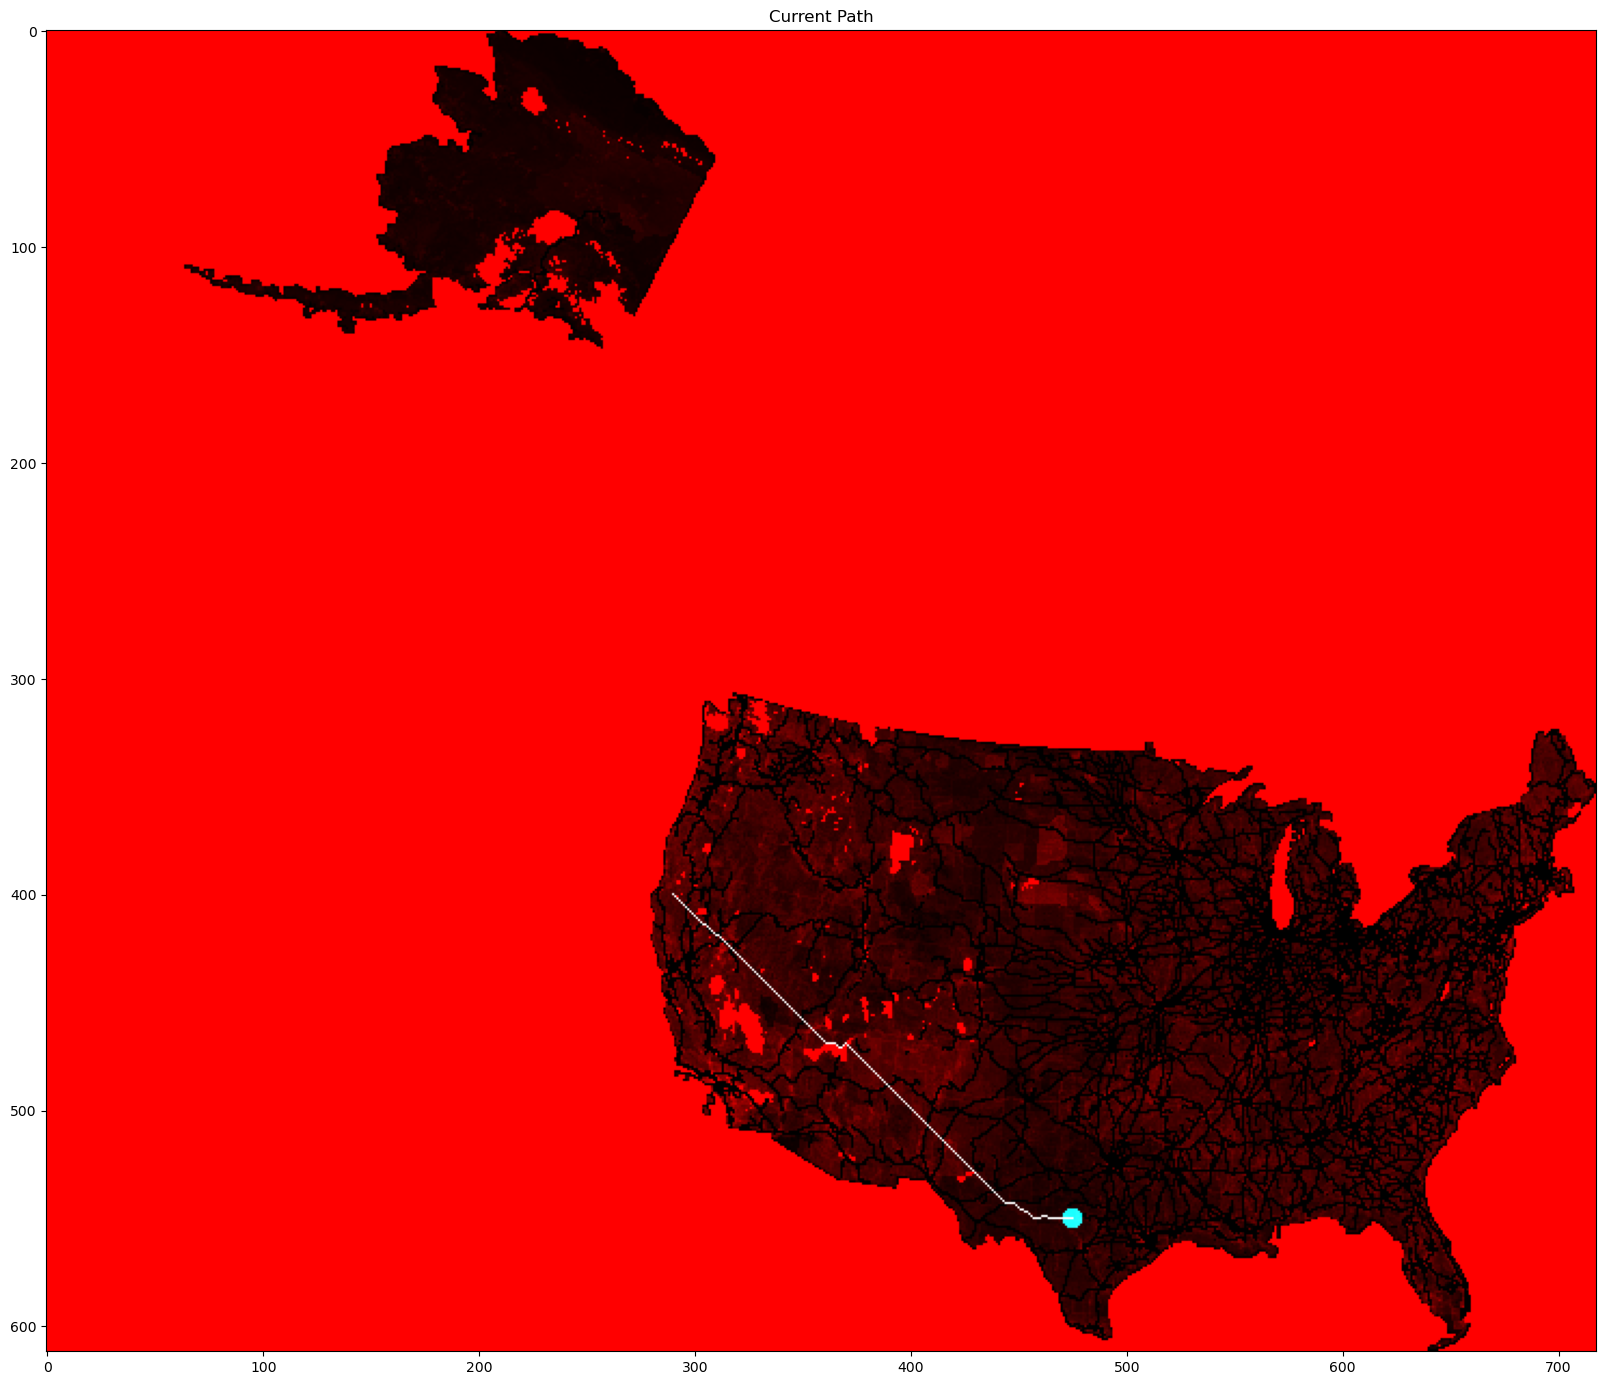

In [13]:
sf = (382, 280)
sa = (526, 343)

ca = [400, 290]
tx = [550, 475]

ml_wrapper = MLWrapper()
# lucy_path, path_using_wrapper = ml_wrapper.route(org_start, org_target)
lucy_path, path_using_wrapper = ml_wrapper.route(ca, tx, show_viz=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


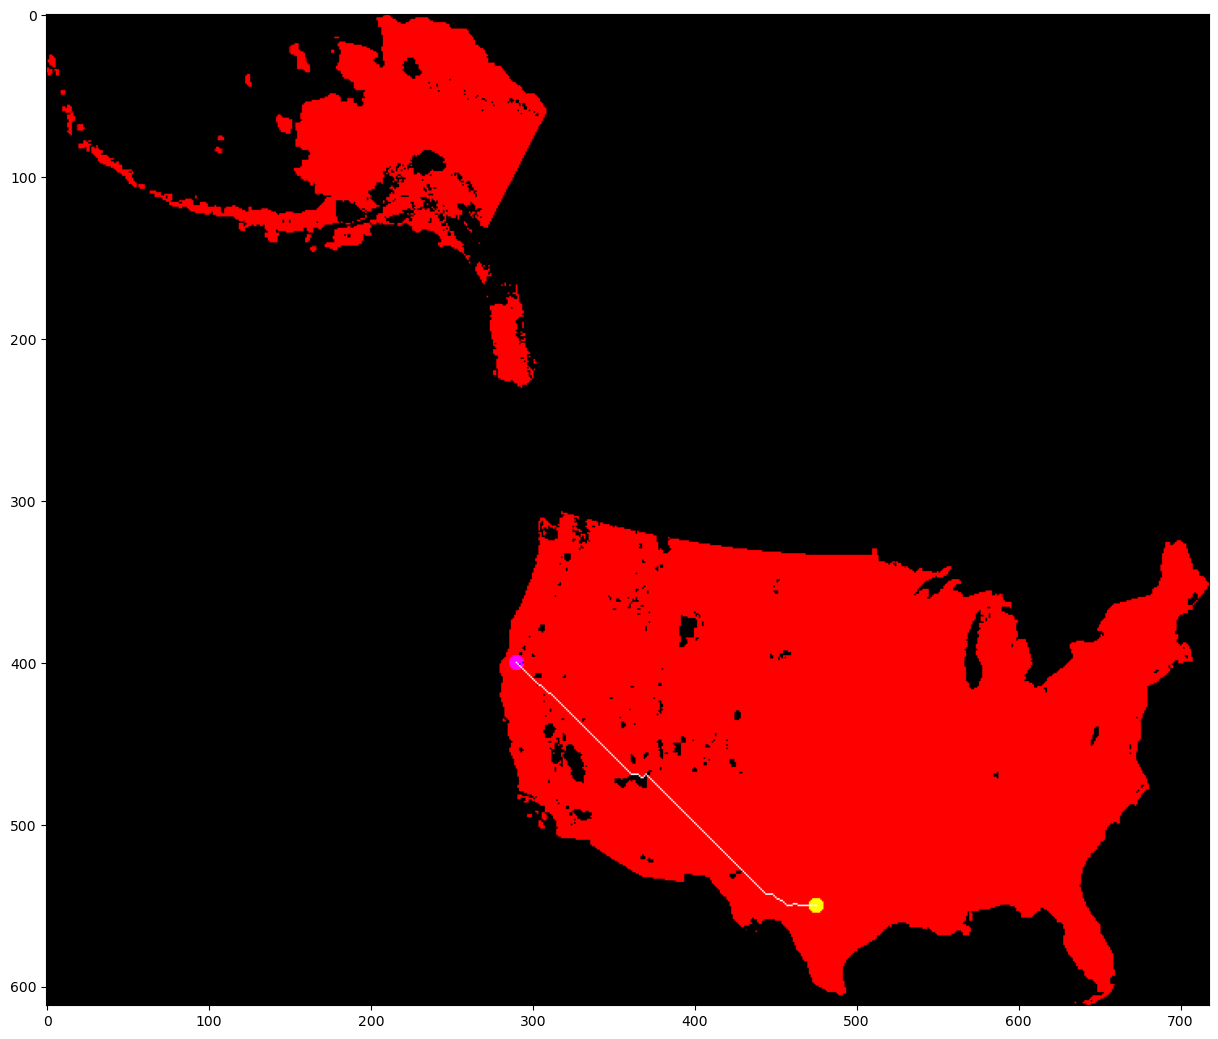

In [14]:
sf = [400, 290]
sa = [550, 475]
obs = visualize(image, sf, sa, path=lucy_path)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.moveaxis(obs, 0, -1))
plt.show()

# Testing exponential cost weighting

Linear:
$$
c = c
$$

Exponential:
$$
c = c^{d}
$$


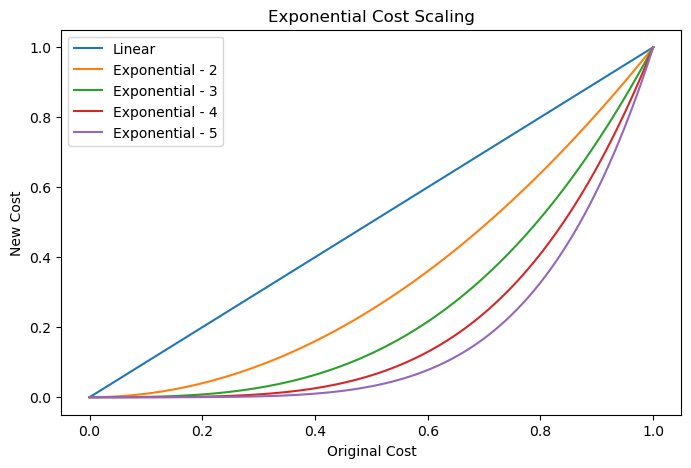

In [15]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_ylabel('New Cost')
ax.set_xlabel('Original Cost')
ax.set_title('Exponential Cost Scaling')

y = normalize(linear(x))
ax.plot(x, y)
labels = ['Linear']
for d in range(2,6):
    y = normalize(exponential(x, d))
    ax.plot(x,y)
    labels.append('Exponential - {}'.format(d))

ax.legend(labels)
plt.show()

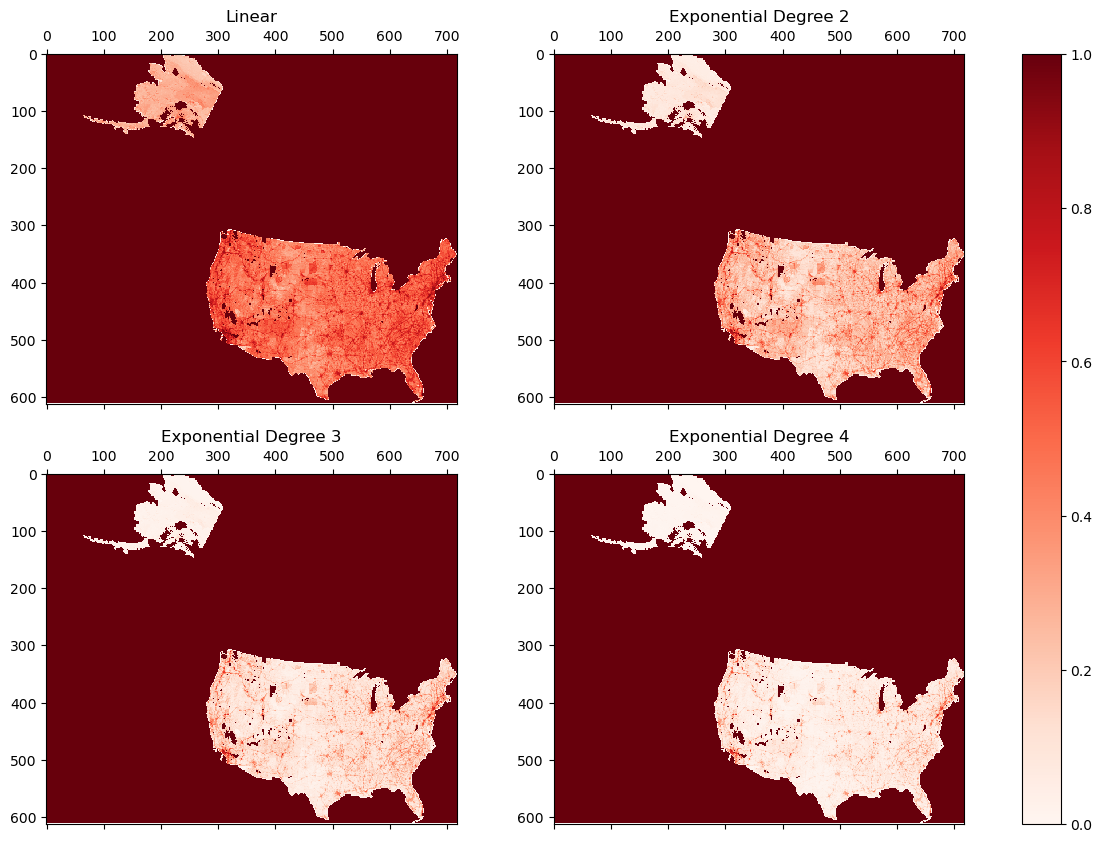

In [16]:
raw_raster_path = './cost_surfaces/raw_cost_10km_aea/cost_10km_aea.tif'
cost_surfaces = []

for i in range(1, 5):
    cs = CostSurface()
    cs.process_raster(raw_raster_path, visualize=False, degree=i)
    cost_surfaces.append(cs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    im = ax.matshow(cost_surfaces[i].cost, cmap="Reds")
    title='Linear' if i==0 else 'Exponential Degree {}'.format(i+1) 
    ax.set_title(title)
    

plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [17]:
paths = []
# Define agent which makes routing choices
start, target = (475, 300), (500, 350)
agent = MCAgent(100, 1)

for i in tqdm.tqdm(range(4)):
    paths.append(
        agent.route(
            cost_surface=cost_surfaces[i].cost,
            start=list(start),
            target=list(target),
            show_viz=False
            )
        )

100%|██████████| 4/4 [01:48<00:00, 27.15s/it]


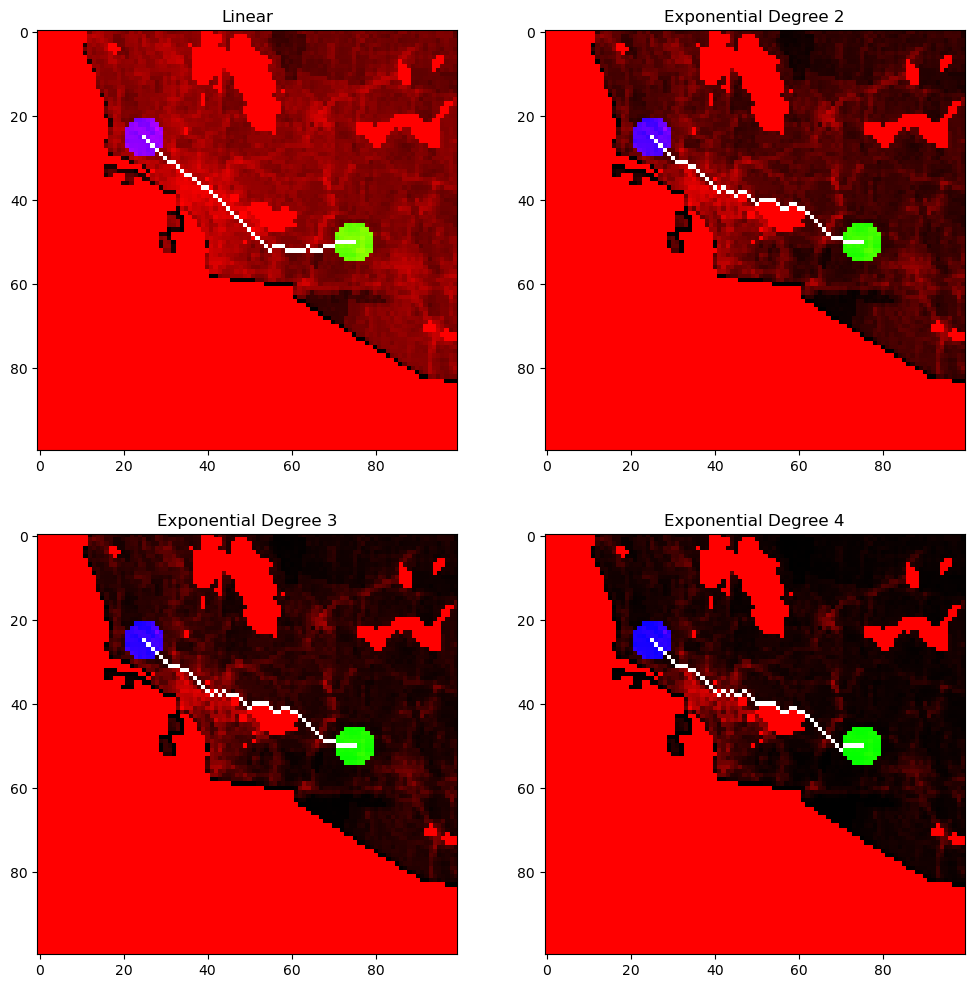

In [18]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

for i, ax in enumerate(axes.flat):
    obs = visualize(cost_surfaces[i].cost, start, target, path=paths[i])
    ax.imshow(np.moveaxis(obs, 0, -1)[450:550, 275:375])
    title='Linear' if i==0 else 'Exponential Degree {}'.format(i+1) 
    ax.set_title(title)

plt.show()